In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import functools
import os
import urllib.request
import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from rdkit import Chem

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[cuda(id=0)]
gpu
[cuda(id=0)]


In [2]:
jax.default_backend()
jax.devices()

[cuda(id=0)]

In [91]:
ZtoName = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F"}

In [28]:
dataset = np.load("../data/qm9-esp10000.npz")

In [29]:
dict(dataset).keys()

dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'n_grid', 'vdw_surface'])

In [30]:
dataset2 = np.load("../data/qm9-esp20000.npz")

In [31]:
dataset2

NpzFile '../data/qm9-esp20000.npz' with keys: R, Z, N, mono, esp...

In [32]:
from rdkit.Chem import MolFromXYZBlock

In [92]:
def r_z_to_mol(R, Z):
    # R /= 0.529177
    # print(R)
    nonzeros = np.where(Z != 0)[0]
    n_atoms = len(R[nonzeros])
    # n_atoms = len(R)#[nonzeros])
    xyz = f"{n_atoms}\n"
    for i in range(n_atoms):
        xyz += f"\n{ZtoName[Z[i]]} {R[i][0]:.3f} {R[i][1]:.3f} {R[i][2]:.3f}"
    # print(xyz)
    return MolFromXYZBlock(xyz)
        

In [93]:
mols = []
smiles = []
for i in range(len(dataset["Z"])):
    mol = r_z_to_mol(dataset["R"][i], dataset["Z"][i])
    mols.append(mol)
    if mol is not None:
        smiles.append(Chem.MolToSmiles(mol))
    else:
        smiles.append(None)

In [94]:
mols2 = []
smiles2 = []
for i in range(len(dataset2["Z"])):
    mol = r_z_to_mol(dataset2["R"][i], dataset2["Z"][i])
    mols2.append(mol)
    if mol is not None:
        smiles2.append(Chem.MolToSmiles(mol))
    else:
        smiles2.append(None)

'C.O.[HH].[HH].[HH].[HH]'

In [79]:
# dir(mol)
mol.GetNumAtoms()

6

In [5]:
a = np.nonzero(dataset["mono"].sum(axis=1).flatten())

In [6]:
zeros = np.where(np.all(dataset["mono"] == 0, axis=1))[0]

In [7]:
dataset["mono"].shape

(10000, 60, 1)

In [8]:
# Total indices range
total_indices = np.arange(dataset["mono"].shape[0])

# Find indices of non-zero arrays
nonzeros_indices = np.setdiff1d(total_indices, zeros)

print(nonzeros_indices)
print(len(nonzeros_indices))

[   0    1    2 ... 9997 9998 9999]
10000


In [92]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

In [ ]:
def check_symmetric_and_traceless(Q):
    """
    Check if the 3x3 matrix Q is symmetric and traceless.

    Parameters:
    Q : numpy.ndarray
        The 3x3 matrix to be checked.

    Returns:
    tuple of bool
        Returns (is_symmetric, is_traceless), where each is a boolean indicating the property.
    """
    # Check symmetry: Q should be equal to its transpose
    is_symmetric = np.allclose(Q, Q.T)
    # Check traceless: Trace of Q should be zero
    is_traceless = np.isclose(np.trace(Q), 0)

    return (is_symmetric, is_traceless)


def make_traceless(Q):
    """
    Adjust the diagonal elements of a 3x3 matrix Q to make it traceless.

    Parameters:
    Q : numpy.ndarray
        The 3x3 matrix to be adjusted.

    Returns:
    numpy.ndarray
        The adjusted 3x3 matrix that is traceless.
    """
    trace_Q = np.trace(Q)
    correction = trace_Q / 3
    Q_traceless = Q.copy()
    np.fill_diagonal(Q_traceless, Q_traceless.diagonal() - correction)

    return Q_traceless

In [203]:
from jax import vmap

def make_traceless(Q):
    trace_Q = jnp.trace(Q, axis1=0, axis2=1)  # Correct axis for trace
    correction = trace_Q / 3
    Q_traceless = Q - jnp.expand_dims(jnp.eye(3) * correction, axis=0)  # Correct shape broadcasting
    return Q_traceless.squeeze()

# Vectorized over each matrix in the 60 matrices group
vectorized_over_matrices = vmap(make_traceless, in_axes=(0), out_axes=(0))

# Then vectorize over the 10000 samples
batch_make_traceless = vmap(vectorized_over_matrices, in_axes=0, out_axes=0)

# (xx, xy, xz, yy, yz, zz)

# xx xy xz
# xy yy yz
# xz yz zz
quad = np.array([-1.2411975 ,  0.00352836,  0.01873389, -1.2184871 , -0.01744576,
       -1.2551148 ])
print(quad)
quad_3_3 = np.array([ [quad[0], quad[1], quad[2]] ,
[quad[1], quad[3], quad[4]],
[quad[2], quad[4], quad[5]],])

print(quad_3_3.shape)

# quad_3_3 = make_traceless(quad_3_3)
print(quad_3_3.shape)
repeated = np.tile(quad_3_3, (2,1,1))
print(repeated.shape)
print(repeated)
print(vectorized_over_matrices(repeated))
repeated_again = np.tile(repeated, (2,1,1,1))
print("---")
print(repeated_again)
batch_make_traceless(repeated_again)

[-1.2411975   0.00352836  0.01873389 -1.2184871  -0.01744576 -1.2551148 ]
(3, 3)
(3, 3)
(2, 3, 3)
[[[-1.2411975   0.00352836  0.01873389]
  [ 0.00352836 -1.2184871  -0.01744576]
  [ 0.01873389 -0.01744576 -1.2551148 ]]

 [[-1.2411975   0.00352836  0.01873389]
  [ 0.00352836 -1.2184871  -0.01744576]
  [ 0.01873389 -0.01744576 -1.2551148 ]]]
[[[-0.002931    0.00352836  0.01873389]
  [ 0.00352836  0.01977932 -0.01744576]
  [ 0.01873389 -0.01744576 -0.01684833]]

 [[-0.002931    0.00352836  0.01873389]
  [ 0.00352836  0.01977932 -0.01744576]
  [ 0.01873389 -0.01744576 -0.01684833]]]
---
[[[[-1.2411975   0.00352836  0.01873389]
   [ 0.00352836 -1.2184871  -0.01744576]
   [ 0.01873389 -0.01744576 -1.2551148 ]]

  [[-1.2411975   0.00352836  0.01873389]
   [ 0.00352836 -1.2184871  -0.01744576]
   [ 0.01873389 -0.01744576 -1.2551148 ]]]


 [[[-1.2411975   0.00352836  0.01873389]
   [ 0.00352836 -1.2184871  -0.01744576]
   [ 0.01873389 -0.01744576 -1.2551148 ]]

  [[-1.2411975   0.00352836  0.01

Array([[[[-0.002931  ,  0.00352836,  0.01873389],
         [ 0.00352836,  0.01977932, -0.01744576],
         [ 0.01873389, -0.01744576, -0.01684833]],

        [[-0.002931  ,  0.00352836,  0.01873389],
         [ 0.00352836,  0.01977932, -0.01744576],
         [ 0.01873389, -0.01744576, -0.01684833]]],


       [[[-0.002931  ,  0.00352836,  0.01873389],
         [ 0.00352836,  0.01977932, -0.01744576],
         [ 0.01873389, -0.01744576, -0.01684833]],

        [[-0.002931  ,  0.00352836,  0.01873389],
         [ 0.00352836,  0.01977932, -0.01744576],
         [ 0.01873389, -0.01744576, -0.01684833]]]], dtype=float32)

In [204]:
def prepare_datasets(key, num_train, num_valid, filename="mulitpoles766000.npz"):
  # Load the dataset.
  dataset = np.load(filename)
    
  for k,v in dataset.items():
      print(k, v.shape)

  num_data = len(dataset["mono"])
  nonzeros = np.where(np.all(dataset["mono"] == 0, axis=1))[0]
  total_indices = np.arange(num_data)
  # Find indices of non-zero arrays
  nonzeros = np.setdiff1d(total_indices, zeros)
  
  dataF =   dataset['F'][nonzeros]
  dataR =   dataset['R'][nonzeros]
  dataZ =   dataset['Z'][nonzeros]
  dataMono =   dataset['mono'][nonzeros]
  dataDip = dataset['dip'][nonzeros]
  dataQuad = dataset['quad'][nonzeros]
    

  indices = np.array([0, 1, 2, 1, 3, 4, 2, 4, 5])
  quad_3_3 = dataQuad[:,:,indices].reshape(dataQuad.shape[0], dataQuad.shape[1], 3, 3)
  print(quad_3_3.shape)
  traceless = batch_make_traceless(quad_3_3)
  dataQuadIrrep = e3x.so3.irreps.tensor_to_irreps(traceless, 2)
    
  # Make sure that the dataset contains enough entries.
  num_data = len(dataR)
  print(num_data)
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # atomic_numbers = jnp.tile(dataset['z'], num_data).reshape((num_data, len(dataset["z"])))
  atomic_numbers = dataZ
    
  # Determine mean energy of the training set.
  # mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000
  mean_energy = 0

  # Collect and return train and validation sets.
  train_data = dict(
    # energy=jnp.asarray(dataset['E'][train_choice] - mean_energy),
    # forces=jnp.asarray(dataF[train_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[train_choice]),
    positions=jnp.asarray(dataR[train_choice]),
    mono=jnp.asarray(dataMono[train_choice]),
    dipo=jnp.asarray(dataDip[train_choice]),
    quad=jnp.asarray(dataQuadIrrep[train_choice]),
  )
  valid_data = dict(
    # energy=jnp.asarray(dataset['E'][valid_choice] - mean_energy),
    # forces=jnp.asarray(dataF[valid_choice]),
    atomic_numbers=jnp.asarray(atomic_numbers[valid_choice]),
    positions=jnp.asarray(dataR[valid_choice]),
    mono=jnp.asarray(dataMono[valid_choice]),
    dipo=jnp.asarray(dataDip[valid_choice]),
    quad=jnp.asarray(dataQuadIrrep[valid_choice]),
  )
  print("...")
  print("...")
  for k,v in train_data.items():
      print(k, v.shape)
  print("...")
  for k,v in valid_data.items():
      print(k, v.shape)
      
  return train_data, valid_data, mean_energy

In [262]:
class QuadrupoleModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 17  


  def mono(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=max_degree,
                               include_pseudotensors=False)(x, basis,
                                                            dst_idx=dst_idx, 
                                                            src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=max_degree, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
          
      y = e3x.nn.add(x, y)
      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)
      # Residual connection.
      x = e3x.nn.add(x, y)

    atomic_quad = e3x.nn.TensorDense(  
        features=self.features,
        max_degree=2, 
        include_pseudotensors=False,
    )(x)
    atomic_quad = e3x.nn.silu(atomic_quad)
    atomic_quad = jnp.sum(atomic_quad, axis=-1)[:,0,4:]

    return atomic_quad


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    return self.mono(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

In [263]:
def prepare_batches(key, data, batch_size):
  # Determine the number of training steps per epoch.
  data_size = len(data['mono'])
  steps_per_epoch = data_size//batch_size

  # Draw random permutations for fetching batches from the train data.
  perms = jax.random.permutation(key, data_size)
  perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
  perms = perms.reshape((steps_per_epoch, batch_size))

  # Prepare entries that are identical for each batch.
  num_atoms = len(data['atomic_numbers'][0])
  batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
  # atomic_numbers = jnp.tile(data['atomic_numbers'], batch_size)
  offsets = jnp.arange(batch_size) * num_atoms
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
  dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
  src_idx = (src_idx + offsets[:, None]).reshape(-1)

  # Assemble and return batches.
  return [
    dict(
        quad=data['quad'][perm].reshape(-1, 5),
        atomic_numbers=data["atomic_numbers"][perm].reshape(-1),
        positions=data['positions'][perm].reshape(-1, 3),
        dst_idx=dst_idx,
        src_idx=src_idx,
        batch_segments = batch_segments,
    )
    for perm in perms
  ]

In [264]:
def mean_squared_loss(quad_prediction, quad_target, batch_size):
  # print("pred", quad_prediction.shape)
  # print("target", quad_target.shape)
  nonzero = jnp.nonzero(quad_prediction, size=batch_size*60)
  quad_rmse = jnp.mean(optax.l2_loss(quad_prediction[nonzero], quad_target[nonzero]))
  return quad_rmse * 1000


def mean_absolute_error(prediction, target,batch_size):
  nonzero = jnp.nonzero(target, size=batch_size*60)
  return jnp.mean(jnp.abs(prediction[nonzero] - target[nonzero]))

In [265]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, opt_state, params):
    
  def loss_fn(params):
    quad = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      quad_prediction=quad,
      quad_target=batch['quad'],
      batch_size = batch_size
    )
    return loss, quad
      
  (loss, (quad)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  quad_mae = mean_absolute_error(quad, batch['quad'], batch_size)
  return params, opt_state, loss, quad_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, params):

    quad = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      quad_prediction=quad,
      quad_target=batch['quad'],
      batch_size = batch_size
    )
    quad_mae = mean_absolute_error(quad, batch['quad'], batch_size)
    return loss, quad_mae


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size,
               restart=None):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers'][0]))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'][0],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  if restart is not None:
      params = restart
  opt_state = optimizer.init(params)

  print("Preparaing batches")
  print("..................")
  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)

    # Loop over train batches.
    train_loss = 0.0
    train_quad_mae = 0.0

    for i, batch in enumerate(train_batches):
      params, opt_state, loss, quad_mae = train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)
      train_quad_mae += (quad_mae - train_quad_mae)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    valid_quad_mae = 0.0
    for i, batch in enumerate(valid_batches):
      loss, quad_mae = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)
      valid_quad_mae += (quad_mae - valid_quad_mae)/(i+1)
        
    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")
    print(f"    quad mae [kcal/mol]   {train_quad_mae: 8.3f} {valid_quad_mae: 8.3f}")

  # Return final model parameters.
  return params

In [270]:
# Model hyperparameters.
features = 16
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0

# Training hyperparameters.
# num_valid = 1000
# num_train = 10000 - num_valid
num_epochs = 20
learning_rate = 0.0001
batch_size = 32

In [283]:
train_data, valid_data, mean_energy = prepare_datasets(data_key, 10000-320, 320, 
                                                       filename="../data/mulitpoles10000.npz")

R (10000, 60, 3)
Z (10000, 60)
N (766110,)
F (10000, 60, 3)
mono (10000, 60, 1)
dip (10000, 60, 3)
quad (10000, 60, 6)
(10000, 60, 6)
(10000, 60, 3, 3)
10000
...
...
atomic_numbers (9680, 60)
positions (9680, 60, 3)
mono (9680, 60, 1)
dipo (9680, 60, 3)
quad (9680, 60, 5)
...
atomic_numbers (320, 60)
positions (320, 60, 3)
mono (320, 60, 1)
dipo (320, 60, 3)
quad (320, 60, 5)


In [284]:
train_data["quad"].shape

(9680, 60, 5)

In [271]:
jax.default_backend()
jax.devices()


[cuda(id=0)]

In [272]:
# Create and train model.
message_passing_model = QuadrupoleModel(
  features=features,
  max_degree=max_degree,
  num_iterations=num_iterations,
  num_basis_functions=num_basis_functions,
  cutoff=cutoff,
)

In [285]:
params = train_model(
  key=train_key,
  model=message_passing_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate,
  batch_size=batch_size,
)

Preparaing batches
..................
epoch:   1                    train:   valid:
    loss [a.u.]                0.110    0.085
    quad mae [kcal/mol]      0.011    0.009
epoch:   2                    train:   valid:
    loss [a.u.]                0.078    0.071
    quad mae [kcal/mol]      0.009    0.008
epoch:   3                    train:   valid:
    loss [a.u.]                0.068    0.065
    quad mae [kcal/mol]      0.008    0.008
epoch:   4                    train:   valid:
    loss [a.u.]                0.064    0.060
    quad mae [kcal/mol]      0.008    0.007
epoch:   5                    train:   valid:
    loss [a.u.]                0.058    0.056
    quad mae [kcal/mol]      0.007    0.007
epoch:   6                    train:   valid:
    loss [a.u.]                0.055    0.052
    quad mae [kcal/mol]      0.007    0.007
epoch:   7                    train:   valid:
    loss [a.u.]                0.051    0.050
    quad mae [kcal/mol]      0.007    0.007
epoch:   8

In [286]:
import pickle
# open a file, where you ant to store the data
with open('quad_params.pkl', 'wb') as file:
    pickle.dump(params, file)

In [304]:
params = train_model(
  key=train_key,
  model=message_passing_model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=100,
  learning_rate=learning_rate,
  batch_size=batch_size,
  restart=params,
)

Preparaing batches
..................
epoch:   1                    train:   valid:
    loss [a.u.]                0.031    0.031
    quad mae [kcal/mol]      0.006    0.006
epoch:   2                    train:   valid:
    loss [a.u.]                0.030    0.030
    quad mae [kcal/mol]      0.006    0.006
epoch:   3                    train:   valid:
    loss [a.u.]                0.030    0.030
    quad mae [kcal/mol]      0.006    0.006
epoch:   4                    train:   valid:
    loss [a.u.]                0.030    0.029
    quad mae [kcal/mol]      0.006    0.006
epoch:   5                    train:   valid:
    loss [a.u.]                0.029    0.029
    quad mae [kcal/mol]      0.006    0.006
epoch:   6                    train:   valid:
    loss [a.u.]                0.028    0.028
    quad mae [kcal/mol]      0.006    0.006
epoch:   7                    train:   valid:
    loss [a.u.]                0.027    0.027
    quad mae [kcal/mol]      0.006    0.006
epoch:   8

In [305]:
import pickle
# open a file, where you ant to store the data
with open('quad_params.pkl', 'wb') as file:
    pickle.dump(params, file)

In [306]:
# params["params"]

def count_shape(array):
    ans = 1
    for shape in array.shape:
        ans *= shape
    return ans

def count_parameters(d):
    if not isinstance(d, dict):  # Base case: not a dictionary
        return 0
    count = 0
    for key, value in d.items():
        if isinstance(value, dict):
            print(key)
            count += count_parameters(value)  # Recursive call if value is a dictionary
        else:
            print(value.shape, count_shape(value))
            count += count_shape(value)  # Count the parameter if it's not a dictionary
    return count

count_parameters(params)

params
Dense_0
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_1
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_2
0+
(16,) 16
(16, 16) 256
0-
(16, 16) 256
1+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
2-
(16, 16) 256
Dense_3
0+
(16,) 16
(16, 16) 256
0-
(16, 16) 256
1+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
2-
(16, 16) 256
Dense_4
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Dense_5
0+
(16,) 16
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
Embed_0
(18, 1, 1, 16) 288
MessagePass_0
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 1, 1, 1, 3, 16) 144
MessagePass_1
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 1, 3, 2, 3, 16) 864
MessagePass_2
filter
0+
(16, 16) 256
1-
(16, 16) 256
2+
(16, 16) 256
tensor
(1, 3, 2, 3, 1, 3, 16) 864
TensorDense_0
dense
0+
(32,) 32
(16, 32) 512
1-
(16, 32) 512
2+
(16, 32) 512
tensor
(1, 3, 1, 3, 1, 3, 16) 432


12704

In [307]:
# valid_data

In [308]:
valid_batches = prepare_batches(data_key, valid_data, batch_size)

In [370]:
batch = valid_batches[-1]
quad = message_passing_model.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
)

In [371]:
quad

Array([[ 1.08448304e-02,  7.86503218e-03,  9.14887618e-03,
         9.16907843e-03, -1.70706566e-02],
       [-1.00060683e-02, -7.40811229e-03,  3.26474616e-03,
         1.39839109e-03,  5.52421343e-03],
       [-1.69336405e-02, -1.27187259e-02, -2.06904057e-02,
        -1.27756502e-03,  1.19461678e-02],
       ...,
       [ 2.62275455e-04,  7.54509092e-05, -6.84863422e-04,
         1.11513495e-04,  4.02718288e-05],
       [ 2.62274552e-04,  7.54511420e-05, -6.84863073e-04,
         1.11513073e-04,  4.02724254e-05],
       [ 2.62274407e-04,  7.54507419e-05, -6.84864237e-04,
         1.11513349e-04,  4.02729929e-05]], dtype=float32)

In [372]:
batch["quad"]

Array([[ 0.01709708,  0.01091302,  0.00237661,  0.01280461, -0.01519156],
       [ 0.00463199, -0.0041227 , -0.00169758,  0.00232811, -0.00807887],
       [-0.01721839, -0.02129252, -0.01392017, -0.00645081,  0.01080912],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

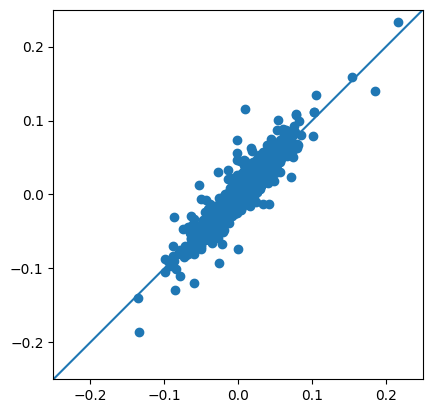

In [373]:
nonzeros = jnp.nonzero(batch["quad"])
import matplotlib.pyplot as plt

plt.scatter(quad[nonzeros].flatten(), batch["quad"][nonzeros].flatten())
plt.plot([-1,1],[-1,1])
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
ax = plt.gca()
ax.set_aspect("equal")

In [321]:
for i in range(10):
    print(quad[nonzeros][i], "\t\t", batch["quad"][nonzeros][i])

0.00058229186 		 -0.0031041682
-0.0031478135 		 -0.0071298415
-0.010146972 		 -0.0042682043
0.0074898545 		 0.012077078
0.019064091 		 0.007896781
0.013337063 		 0.009651952
-0.0017942791 		 -0.0030556463
-0.01783869 		 -0.0063538044
0.047361985 		 0.045155663
-0.052379638 		 -0.044076443


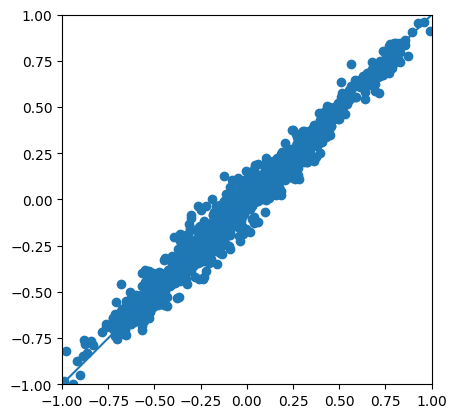

In [79]:
import matplotlib.pyplot as plt
# for i in range(10):
#     plt.scatter(batch_gt[i], patch_pred[i])
plt.scatter(mono[nonzeros], batch["mono"][nonzeros])
plt.plot([-1,1],[-1,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
ax = plt.gca()
ax.set_aspect("equal")

#  Equivariance

In [340]:
key, rotation_key = jax.random.split(data_key)
rotation = e3x.so3.random_rotation(rotation_key)
wigner_d = e3x.so3.wigner_d(rotation, max_degree=2)

In [341]:
rotation

Array([[ 0.05268008,  0.32747042, -0.9433917 ],
       [ 0.9180192 , -0.38768542, -0.08331031],
       [-0.3930209 , -0.8616629 , -0.3210473 ]], dtype=float32)

In [342]:
batch = valid_batches[0]
quad_rot = message_passing_model.apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions']@rotation,
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=len(valid_data["atomic_numbers"])
)

In [343]:
nonzeros = jnp.nonzero(batch["atomic_numbers"])

In [365]:
# plt.scatter(quad[nonzeros]@rotation, quad_rot[nonzeros])

In [347]:
wigner_d.shape

(9, 9)

In [360]:
quad[nonzeros][0]

Array([ 0.00058229, -0.00314781, -0.01014697,  0.00748985,  0.01906409],      dtype=float32)

In [366]:
sph = e3x.so3.irreps.spherical_harmonics(jnp.asarray([0.1, 0.1, 0.1]), max_degree=2)
for i in range(4,10):
    sph = sph.at[i].set(quad[nonzeros][0][i-4])
sph

Array([ 1.0000000e+00,  5.7735032e-01,  5.7735032e-01,  5.7735032e-01,
        5.8229186e-04, -3.1478135e-03, -1.0146972e-02,  7.4898545e-03,
        1.9064091e-02], dtype=float32)

In [367]:
rot_sph = sph @ wigner_d

In [368]:
e3x.so3.irreps.irreps_to_tensor(rot_sph[4:], 2) #@rotation

Array([[-0.00674594,  0.0043305 ,  0.00079048],
       [ 0.0043305 ,  0.01444184,  0.00124634],
       [ 0.00079048,  0.00124634, -0.0076959 ]], dtype=float32)

In [369]:
e3x.so3.irreps.irreps_to_tensor(quad_rot[nonzeros][0], 2)

Array([[-0.00674596,  0.0043305 ,  0.00079048],
       [ 0.0043305 ,  0.01444184,  0.00124633],
       [ 0.00079048,  0.00124633, -0.00769589]], dtype=float32)